In [44]:
import numpy as np
import scipy
import scipy.io
import pandas as pd
from pathlib import Path
import os
import collections
from natsort import natsorted
import json
import pickle
from pprint import pprint

from mne_bids import BIDSPath, get_entities_from_fname, get_entity_vals

from sklearn.metrics import auc

import pingouin as pg
from mlxtend.evaluate import mcnemar_table, mcnemar
import dabest

import sys

sys.path.append("../../")
from episcalp.utils.standard_1020_montage import get_standard_1020_montage

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
# Set font sizes
SMALL_SIZE = 8 * 2
MEDIUM_SIZE = 10 * 2
BIGGER_SIZE = 12 * 2

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rc("font", **{"family": "sans-serif", "sans-serif": ["Arial"]})

In [46]:
def load_participant_df(root, subject):
    """Load participants.tsv file as a dataframe for a specific subject.

    Note: subject ID needs to be in format ``sub-<subject>``.
    """
    df = pd.read_csv(os.path.join(root, "participants.tsv", sep="\t"))
    if not subject.startswith("sub-"):
        subject = f"sub-{subject}"
    subj_row = df[df["participant_id"] == subject]
    return subj_row

In [47]:
jhroot = Path("D:/OneDriveParent/OneDrive - Johns Hopkins/Shared Documents/bids")
jeffroot = Path("D:/OneDriveParent/Johns Hopkins/Jefferson_Scalp - Documents/root")

# not ready yet
upmcroot = Path(
    "D:/OneDriveParent/Johns Hopkins/UPMC_Scalp - Documents/scalp_study/root"
)

In [48]:
root = Path("D:/OneDriveParent/OneDrive - Johns Hopkins/Shared Documents/bids")
# root = Path("/home/adam2392/hdd/Dropbox/epilepsy_interictal")
deriv_root = root / "derivatives"
deriv_path = deriv_root

In [49]:
figure_dir = deriv_root / "figures"

In [88]:
# here name the experiment something that is uniquely identifiable
# THIS STR WILL BE USED TO PREFIX/SUFFIX ALL FIGURES DOWNSTREAM
exp_name = "fragility_alphaO1O2"
#exp_name = "spikes_benchmark"

In [51]:
n_splits = 10

clf_name = "rf"
# clf_name = "lr"
max_features = 28

In [89]:
# specify the filenmae
fname = (
    deriv_root
    / f"cv{n_splits}_{clf_name}_mtry{max_features}_exp_{exp_name}_multiclass.json"  # _without_abnormaleeg.json"
)
print(fname)

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\cv10_rf_mtry28_exp_fragility_alphaO1O2_multiclass.json


In [90]:
with open(fname.with_suffix(".json"), "r") as fp:
    scores = json.load(fp)

In [91]:
ch_names = get_standard_1020_montage()
print(len(ch_names))

ch_names = [
    "Fp1",
    "Fp2",
    "F3",
    "F4",
    #"C3",
    #"C4",
    "P3",
    "P4",
    "O1",
    "O2",
    "F7",
    "F8",
    "T3",
    "T4",
    "T5",
    "T6",
]

23


In [92]:
meta_df = pd.DataFrame()
for root in [jhroot, jeffroot]:
    df = pd.read_csv(os.path.join(root, "participants.tsv"), sep="\t")
    meta_df = pd.concat((meta_df, df), axis=0)

# meta_df = pd.concat(df_list, axis=0)

display(meta_df.head())

,participant_id,age,sex,hand,site,exp_condition,orig_sub_id
0,sub-jhh001,NaN,NaN,NaN,BV,non-epilepsy-normal-eeg,NaN
1,sub-jhh002,NaN,NaN,NaN,BV,non-epilepsy-normal-eeg,NaN
2,sub-jhh003,NaN,NaN,NaN,BV,non-epilepsy-normal-eeg,NaN
3,sub-jhh004,NaN,NaN,NaN,BV,non-epilepsy-normal-eeg,NaN
4,sub-jhh005,NaN,NaN,NaN,BV,non-epilepsy-normal-eeg,NaN


In [15]:
scores.keys()

dict_keys(['fit_time', 'score_time', 'test_score', 'train_score', 'test_fraction_pos', 'test_mean_pred_value', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'train_fraction_pos', 'train_mean_pred_value', 'train_y_pred_proba', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_subjects', 'test_subjects', 'test_y_pred_proba', 'test_importances', 'test_specificity', 'test_y', 'test_y_encodings'])

In [93]:
# either train or test set
which_set = "test"

# construct mean/std ROC curves
tprs = collections.defaultdict(list)
groups = [0, 1, 2]
#aucs = scores[f"{which_set}_roc_auc"]
mean_fpr = np.linspace(0, 1, 100)

mean_tpr = collections.defaultdict(list)
std_tpr = collections.defaultdict(list)
tprs_lower = collections.defaultdict(list)
tprs_upper = collections.defaultdict(list)

for gdx in groups:
    for idx in range(n_splits):
        fpr = scores[f"{which_set}_fpr"][idx][f"{gdx}"]
        tpr = scores[f"{which_set}_tpr"][idx][f"{gdx}"]

        # interpolate the tpr
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs[f"{gdx}"].append(interp_tpr)

    
    mean_tpr[f"{gdx}"] = np.mean(tprs[f"{gdx}"], axis=0)
    mean_tpr[f"{gdx}"][-1] = 1.0
    mean_auc[f"{gdx}"] = auc(mean_fpr, mean_tpr[f"{gdx}"])
    #mean_auc[f"{gdx}"] = np.mean(aucs)
    #std_auc[f"{gdx}"] = np.std(aucs)

    std_tpr[f"{gdx}"] = np.std(tprs[f"{gdx}"], axis=0)
    tprs_upper[f"{gdx}"] = np.minimum(mean_tpr[f"{gdx}"] + std_tpr[f"{gdx}"], 1)
    tprs_lower[f"{gdx}"] = np.maximum(mean_tpr[f"{gdx}"] - std_tpr[f"{gdx}"], 0)

In [94]:
metric = "test_specificity"
score_0 = [met['0'] for met in scores[metric]]
print(metric, "label: 0", np.mean(score_0), "+/-", np.std(score_0))

score_1 = [met['1'] for met in scores[metric]]
print(metric, "label: 1", np.mean(score_1), "+/-", np.std(score_1))

score_2 = [met['2'] for met in scores[metric]]
print(metric, "label: 2", np.mean(score_2), "+/-", np.std(score_2))

test_specificity label: 0 0.04027777777777778 +/- 0.03632415786283894
test_specificity label: 1 0.9127272727272727 +/- 0.10007848159988662
test_specificity label: 2 1.0 +/- 0.0


In [95]:
# create a dataframe from the statistics
temp_scores = scores.copy()
keys = list(temp_scores.keys())
for key in keys:
    if any(
        [
            chars in key
            for chars in [
                "fpr",
                "tpr",
                "fnr",
                "tnr",
                "threshold",
                "fraction_pos",
                "mean_pred_value",
                "subjects",
                "y_pred_proba",
                "importances",
                "train",
            ]
        ]
    ):
        temp_scores.pop(key)
score_df = pd.DataFrame(temp_scores)

display(score_df.head())

,fit_time,score_time,test_score,test_specificity,test_y,test_y_encodings
0,1.941436,0.078017,0.574486,"{'0': 0.0, '1': 0.8181818181818182, '2': 1.0}","[1, 1, 2, 0, 2, 0, 1, 1, 2, 1, 1, 0, 2, 2, 0, ...","[epilepsy-normal-eeg, epilepsy-normal-eeg, epi..."
1,0.558125,0.083019,0.559465,"{'0': 0.0, '1': 1.0, '2': 1.0}","[1, 0, 0, 0, 0, 2, 1, 0, 2, 1, 1, 1, 2, 0, 2, ...","[epilepsy-normal-eeg, non-epilepsy-normal-eeg,..."
2,0.554124,0.080018,0.686728,"{'0': 0.05555555555555555, '1': 0.9, '2': 1.0}","[0, 1, 2, 0, 2, 0, 0, 2, 1, 1, 2, 1, 2, 0, 0, ...","[non-epilepsy-normal-eeg, epilepsy-normal-eeg,..."
3,0.551124,0.080018,0.681584,"{'0': 0.1111111111111111, '1': 1.0, '2': 1.0}","[0, 1, 0, 1, 2, 2, 0, 2, 2, 1, 2, 0, 1, 2, 0, ...","[non-epilepsy-normal-eeg, epilepsy-normal-eeg,..."
4,0.542121,0.077017,0.539300,"{'0': 0.0625, '1': 0.75, '2': 1.0}","[1, 0, 2, 1, 2, 2, 0, 2, 1, 2, 0, 0, 0, 0, 1, ...","[epilepsy-normal-eeg, non-epilepsy-normal-eeg,..."


In [96]:
score_df.describe().to_csv(figure_dir / f"{exp_name}_{exp_name}_metrics_meansstd.csv")

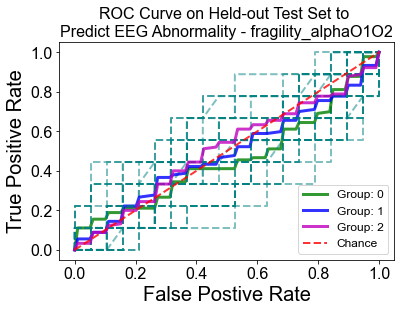

In [97]:
fig, ax = plt.subplots()
colors=['g', 'b', 'm']

for gdx in groups:
    for idx in range(n_splits):
        fpr = scores[f"{which_set}_fpr"][idx][f"{gdx}"]
        tpr = scores[f"{which_set}_tpr"][idx][f"{gdx}"]

        ax.plot(fpr, tpr, color="teal", lw=2, alpha=0.5, ls="--")
    ax.plot(
        mean_fpr,
        mean_tpr[f"{gdx}"],
        label=f"Group: {gdx}",
        color=colors[gdx],
        lw=3,
        alpha=0.8,
    )

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)


ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"ROC Curve on Held-out Test Set to \nPredict EEG Abnormality - {exp_name}",
    xlabel="False Postive Rate",
    ylabel="True Positive Rate",
)
ax.legend(loc="lower right", fontsize=12)

# And save it to PDF
fig.savefig(
    figure_dir / f"roc_curve_{exp_name}_withoutabnormaleeg.pdf", bbox_inches="tight"
)

In [98]:
# TODO: modify to fit the participants framework
y_probas_non_epilepsy = []
y_probas_epilepsy_normal = []
y_probas_epilepsy_abnormal = []
subj_list = []
exp_conditions = []
y_outcomes = []
centers = []
folds = []

for idx in range(n_splits):
    y_pred_proba = scores[f"{which_set}_y_pred_proba"][idx]
    cv_subjects = scores[f"{which_set}_subjects"][idx]
    for sdx, subject in enumerate(cv_subjects):
        y_pred = y_pred_proba[sdx]
        outcome = meta_df[meta_df["participant_id"] == f"sub-{subject}"][
            "exp_condition"
        ].values[0]

        # this should match the original
        if outcome == "epilepsy-normal-eeg":
            y_outcome = 1
        elif outcome == "epilepsy-abnormal-eeg":
            y_outcome = 2
        else:
            y_outcome = 0
        y_outcomes.append(y_outcome)
        exp_conditions.append(outcome)
        
        y_probas_non_epilepsy.append(y_pred[0])
        y_probas_epilepsy_normal.append(y_pred[1])
        y_probas_epilepsy_abnormal.append(y_pred[2])

        if subject.startswith("jhh"):
            center = "JHH"
        elif subject.starstwith("jeff"):
            center = "Jefferson"
        elif subject.startswith("upmc"):
            center = "UPMC"
        centers.append(center)

    subj_list.extend(cv_subjects)
    folds.extend([idx] * len(cv_subjects))

In [99]:
proba_df = pd.DataFrame(
    (y_probas_non_epilepsy, y_probas_epilepsy_normal, y_probas_epilepsy_abnormal, subj_list, exp_conditions, y_outcomes, centers, folds)
).T
proba_df.columns = ["y_proba_non_epilepsy", "y_proba_epilepsy_normal", "y_proba_epilepsy_abnormal", "subject", "exp_condition", "outcome", "center", "fold"]

display(proba_df.head())

,y_proba_non_epilepsy,y_proba_epilepsy_normal,y_proba_epilepsy_abnormal,subject,exp_condition,outcome,center,fold
0,0.152,0.377,0.471,jhh124,epilepsy-normal-eeg,1,JHH,0
1,0.211,0.44,0.349,jhh118,epilepsy-normal-eeg,1,JHH,0
2,0.186,0.421,0.393,jhh228,epilepsy-abnormal-eeg,2,JHH,0
3,0.178,0.431,0.391,jhh006,non-epilepsy-normal-eeg,0,JHH,0
4,0.175,0.354,0.471,jhh210,epilepsy-abnormal-eeg,2,JHH,0


[Text(0, 0.5, 'Predicted Probability of Non-Epilepsy'),
 Text(0.5, 0, 'Experimental Condition')]

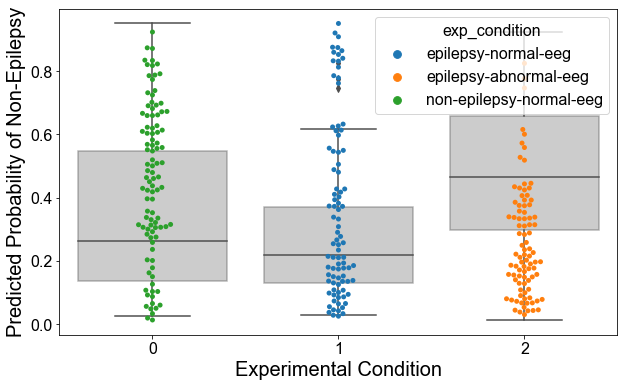

In [100]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(
    x="exp_condition",
    y="y_proba_non_epilepsy",
    color="gray",
    data=proba_df,
    ax=ax,
    boxprops=dict(alpha=0.4),
)
sns.swarmplot(
    x="outcome",
    y="y_proba_non_epilepsy",
    hue="exp_condition",
    #               color="black",
    data=proba_df,
    ax=ax,
)

ax.set(
    ylabel="Predicted Probability of Non-Epilepsy",
    xlabel="Experimental Condition",
)
# fig.savefig(figure_dir / f"{exp_name}_y_pred_proba_surgical_outcomes.pdf", bbox_inches="tight")

[Text(0, 0.5, 'Predicted Probability of Epilepsy Normal'),
 Text(0.5, 0, 'Experimental Condition')]

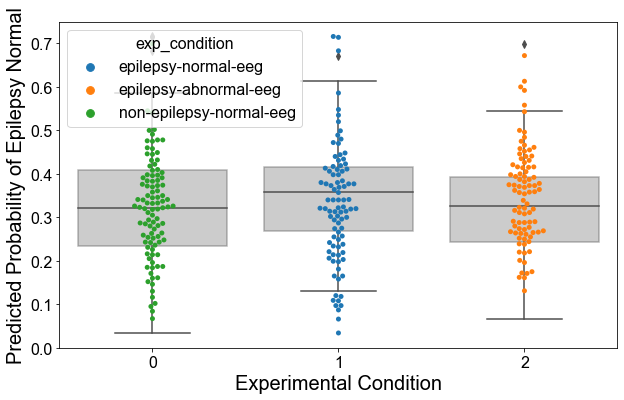

In [101]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(
    x="exp_condition",
    y="y_proba_epilepsy_normal",
    color="gray",
    data=proba_df,
    ax=ax,
    boxprops=dict(alpha=0.4),
)
sns.swarmplot(
    x="outcome",
    y="y_proba_epilepsy_normal",
    hue="exp_condition",
    #               color="black",
    data=proba_df,
    ax=ax,
)

ax.set(
    ylabel="Predicted Probability of Epilepsy Normal",
    xlabel="Experimental Condition",
)

[Text(0, 0.5, 'Predicted Probability of Epilepsy Abnormal'),
 Text(0.5, 0, 'Experimental Condition')]

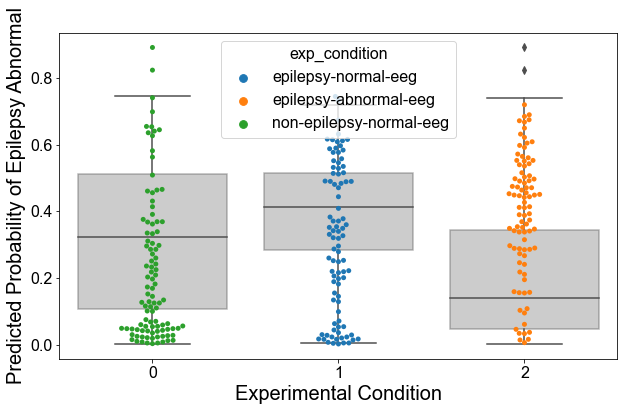

In [102]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(
    x="exp_condition",
    y="y_proba_epilepsy_abnormal",
    color="gray",
    data=proba_df,
    ax=ax,
    boxprops=dict(alpha=0.4),
)
sns.swarmplot(
    x="outcome",
    y="y_proba_epilepsy_abnormal",
    hue="exp_condition",
    #               color="black",
    data=proba_df,
    ax=ax,
)

ax.set(
    ylabel="Predicted Probability of Epilepsy Abnormal",
    xlabel="Experimental Condition",
)

               exp_condition                   variable  value
0        epilepsy-normal-eeg       y_proba_non_epilepsy  0.152
1        epilepsy-normal-eeg       y_proba_non_epilepsy  0.211
2      epilepsy-abnormal-eeg       y_proba_non_epilepsy  0.186
3    non-epilepsy-normal-eeg       y_proba_non_epilepsy  0.178
4      epilepsy-abnormal-eeg       y_proba_non_epilepsy  0.175
..                       ...                        ...    ...
835      epilepsy-normal-eeg  y_proba_epilepsy_abnormal  0.249
836      epilepsy-normal-eeg  y_proba_epilepsy_abnormal  0.044
837    epilepsy-abnormal-eeg  y_proba_epilepsy_abnormal  0.598
838  non-epilepsy-normal-eeg  y_proba_epilepsy_abnormal  0.431
839  non-epilepsy-normal-eeg  y_proba_epilepsy_abnormal  0.369

[840 rows x 3 columns]


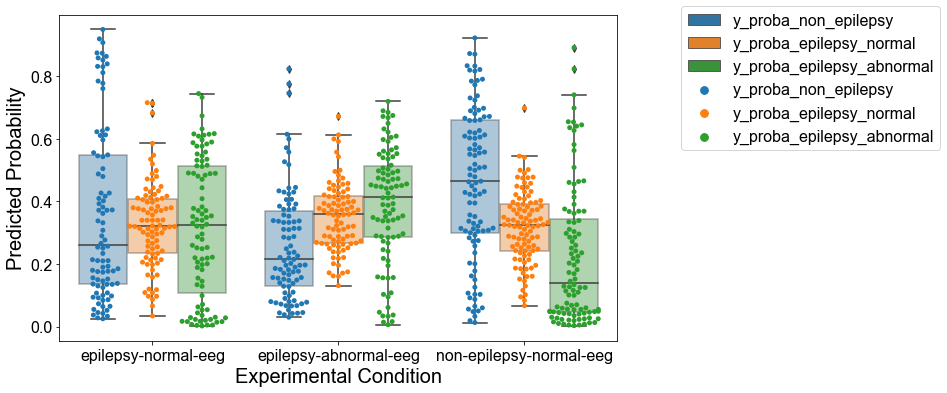

In [114]:
long_df = pd.melt(proba_df, id_vars=['exp_condition'], value_vars=["y_proba_non_epilepsy", "y_proba_epilepsy_normal", "y_proba_epilepsy_abnormal"])
print(long_df)
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(
    x="exp_condition",
    y="value",
    hue="variable",
    data=long_df,
    ax=ax,
    boxprops=dict(alpha=0.4),
)
sns.swarmplot(
    x="exp_condition",
    y="value",
    hue="variable",
    #               color="black",
    data=long_df,
    ax=ax,
    dodge=True,
    label=None
)

ax.set(
    ylabel="Predicted Probability",
    xlabel="Experimental Condition",
)
ax.legend(bbox_to_anchor=(1.1, 1.05))

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.axhline([0.5], ls="--", label="decision boundary")
# sns.boxplot(
#     x="center",
#     y="y_proba",
#     data=proba_df,
#     color="gray",
#     ax=ax,
#     boxprops=dict(alpha=0.4),
# )
sns.swarmplot(x="center", y="y_proba", hue="outcome", data=proba_df, ax=ax)
ax.set(
    ylabel="Predicted Probability of Epilepsy",
    xlabel="Clinical Center",
)
ax.legend(fontsize=12)
# fig.savefig(figure_dir / f"{exp_name}_boundary_split_center.pdf", bbox_inches="tight")

In [ ]:
mean_brier = np.mean(scores["test_neg_brier_score"])
std_brier = np.std(scores["test_neg_brier_score"])

In [ ]:
frac_pred_vals = []
mean_pred_values = np.linspace(0, 1.0, 200)

fig, ax = plt.subplots(figsize=(9, 6))
color = "blue"
for idx in range(n_splits):
    y_pred_proba = scores[f"{which_set}_y_pred_proba"][idx]

    mean_predicted_value = scores[f"{which_set}_mean_pred_value"][idx]
    fraction_of_positives = scores[f"{which_set}_fraction_pos"][idx]

    # create a linear interpolation of the calibration
    interp_frac_positives = np.interp(
        mean_pred_values, mean_predicted_value, fraction_of_positives
    )

    # store curves
    frac_pred_vals.append(interp_frac_positives)
#     ax.plot(mean_pred_values, interp_frac_positives, "s-", alpha=0.5)

# get the mean calibration curve
mean_frac_pred_values = np.mean(frac_pred_vals, axis=0)
ax.plot(
    mean_pred_values,
    mean_frac_pred_values,
    "s-",
    label=rf"(Neg. Brier Loss = {np.round(mean_brier,3)} $\pm$ {np.round(std_brier, 3)})",
)

# get upper and lower bound for tpr
std_fpv = np.std(frac_pred_vals, axis=0)
tprs_upper = np.minimum(mean_frac_pred_values + std_fpv, 1)
tprs_lower = np.maximum(mean_frac_pred_values - std_fpv, 0)
ax.fill_between(
    mean_pred_values,
    tprs_lower,
    tprs_upper,
    color=color,
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)
ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")


ax.set(
    ylabel="Fraction of Epilepsy Outcomes",
    ylim=[-0.05, 1.05],
    xlabel="Mean Predicted Probabilities of Subjects Being Epileptic",
    title="Calibration (Reliability) Curve",
)

ax.legend(loc="lower right", fontsize=12)

# fig.savefig(figure_dir / f"{exp_name}_calibration_curve.pdf", bbox_inches="tight")